## imports and files

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import json
from copy import deepcopy
import random
import sys

# get an absolute path to the directory that contains parent files
__file__ = globals()['_dh'][0]
project_dir = __file__ = globals()['_dh'][0]
sys.path.append(os.path.normpath(os.path.join(
    project_dir, '..', '..', '..')))

from experiments.utils.constants import (
    PIPLINES_PATH,
    NODE_PROFILING_CONFIGS_PATH,
    NODE_PROFILING_RESULTS_STATIC_PATH
)


In [13]:
series = 1
config_key_mapper = "key_config_mapper.csv"
series_path = os.path.join(
    NODE_PROFILING_RESULTS_STATIC_PATH,
    'series',
    str(series))

## config map reader

In [14]:
def config_reader(csv_addr: str):
    config_path = os.path.join(
        series_path,
        csv_addr)
    key_config_df = pd.read_csv(config_path)
    return key_config_df    

In [15]:
def get_experiment_detail(experiment_id: str):
    path = os.path.join(
        series_path,        
        config_key_mapper
    )
    df = config_reader(config_key_mapper)
    return df[df["experiment_id"]==experiment_id]

In [16]:
key_config_df = config_reader(config_key_mapper)
key_config_df

,experiment_id,pipeline_name,node_name,model_variant,cpu_request,memory_request,max_batch_size,max_batch_time,load,load_duration,series,series_meta,replicas
0,1,1-paper-audio-qa,audio,facebook/s2t-small-librispeech-asr,16,40Gi,1,1,10,60,1,testing static trace,1
1,2,1-paper-audio-qa,audio,facebook/s2t-small-librispeech-asr,16,40Gi,1,1,10,60,1,testing static trace,1
2,3,1-paper-audio-qa,audio,facebook/s2t-small-librispeech-asr,16,40Gi,1,1,10,60,1,testing static trace,1


In [17]:
get_experiment_detail(2)

,experiment_id,pipeline_name,node_name,model_variant,cpu_request,memory_request,max_batch_size,max_batch_time,load,load_duration,series,series_meta,replicas
1,2,1-paper-audio-qa,audio,facebook/s2t-small-librispeech-asr,16,40Gi,1,1,10,60,1,testing static trace,1


In [18]:
def get_result_file_names(results_addr):
    files = []
    key_config = config_reader(config_key_mapper)
    experiments_keys = list(key_config["experiment_id"])
    for path in os.listdir(results_addr):
        if os.path.isfile(os.path.join(results_addr, path)):
            file_name = path.split(".")[0]
            try:
                if int(file_name) in experiments_keys:
                    files.append(path)
            except:
                pass
    return files
file_names = get_result_file_names(
    results_addr=series_path)
file_names

['1.json', '3.json', '2.json']

## Read resutls

In [19]:
def read_results(
    results_addr, return_type = "all", specific_file = None):
    files = get_result_file_names(results_addr=results_addr)
    
    if return_type == "all":
        return_results = {}
        for file in files:
            name = file.split(".")[0].split("/")[-1]
            full_path = os.path.join(
                results_addr, file
            )
            json_file = open(full_path)
            return_results[name] = json.load(json_file)
        return return_results

            
results = read_results(
    results_addr=series_path)
print(results.keys())


dict_keys(['1', '3', '2'])


In [20]:
def latency_calculator(results):
    latencies = []
    for result in results:
        data = result['outputs'][0]['data']
        model_name = result['model_name']
        arrival_key = "arrival_" + model_name
        serve_key   = "serving_" + model_name
        data = json.loads(data[0])
        time = data["time"]
        latency = time[serve_key] - time[arrival_key]
        latencies.append(latency)
    return sum(latencies) / len(latencies)

latency_calculator(results) 

TypeError: string indices must be integers

In [69]:
def flatten_results(per_second_latencies):
    """
    change the results format from
    [[second_1], [second_2], ...]
    to:
    [req_1, req_2, ...]
    """
    flattend_results = []
    for second_results in per_second_latencies:
        for request_result in second_results:
            flattend_results.append(request_result)
    return flattend_results

def latency_calculator(results):
    latencies = []
    results = flatten_results(results)
    for result in results:
        data = result['outputs'][0]['data']
        model_name = result['model_name']
        arrival_key = "arrival_" + model_name
        serve_key   = "serving_" + model_name
        data = json.loads(data[0])
        time = data["time"]
        latency = time[serve_key] - time[arrival_key]
        latencies.append(latency)
    return sum(latencies) / len(latencies)










# def result_processing(
#     kind_processing = "all",
#     metrics = ["all"],
#     functions = [],
#     specific_experiments = []):
#     results = read_results(
#         results_addr=NODE_PROFILING_RESULTS_STATIC_PATH)            
#     final_dataframe = []
#     if kind_processing == "all":   
#         if metrics[0] == "all":
#             for key in results.keys():
#                 current_result_key = [random.randint(0, 100)]
#                 data = results[key]
#                 if len(functions) == 0:
#                     for metric in data.keys():
#                         metric_result = data[metric]
#                         print(metric)
#                         # cpu and memory time
#                         if "time_cpu" == metric or "time_memory" == metric:
#                             current_result_key.append(
#                                 metric_result[0]) # TODO why?
#                         # extracting latency metric
#                         elif metric == "responses":
#                             current_result_key.append(
#                                 latency_calculator(metric_result))
#                         else:
#                             try:
#                                 current_result_key.append(
#                                     max(metric_result))
#                             except:
#                                 current_result_key.append(0)
#                 current_result_key[0] = random.randint(0, 100)

#                 final_dataframe.append(current_result_key)
#                 new_data = deepcopy(current_result_key)
#                 new_data[0] = random.randint(0, 100)
#                 final_dataframe.append(new_data)
#                 new_data = deepcopy(current_result_key)
#                 new_data[0] = random.randint(0, 100)
#                 final_dataframe.append(new_data)
#                 new_data = deepcopy(current_result_key)
#                 new_data[0] = random.randint(0, 100)
#                 final_dataframe.append(new_data)
#                 new_data = deepcopy(current_result_key)
#                 new_data[0] = random.randint(0, 100)
#                 final_dataframe.append(new_data)
                
            
#             return final_dataframe
        
results = result_processing()
results


cpu_usage
time_cpu
memory_usage
time_memory
responses
start_time
end_time
latency
throughput
cpu_usage
time_cpu
memory_usage
time_memory
responses
start_time
end_time
latency
throughput
cpu_usage
time_cpu
memory_usage
time_memory
responses
start_time
end_time
latency
throughput


[[33,
  16.005471670671927,
  1666470132.0,
  1668259840.0,
  1666470107.0,
  0.45328696807225544,
  0,
  0,
  0,
  0],
 [93,
  16.005471670671927,
  1666470132.0,
  1668259840.0,
  1666470107.0,
  0.45328696807225544,
  0,
  0,
  0,
  0],
 [67,
  16.005471670671927,
  1666470132.0,
  1668259840.0,
  1666470107.0,
  0.45328696807225544,
  0,
  0,
  0,
  0],
 [71,
  16.005471670671927,
  1666470132.0,
  1668259840.0,
  1666470107.0,
  0.45328696807225544,
  0,
  0,
  0,
  0],
 [19,
  16.005471670671927,
  1666470132.0,
  1668259840.0,
  1666470107.0,
  0.45328696807225544,
  0,
  0,
  0,
  0],
 [59,
  16.00387647818434,
  1666470775.0,
  1670365184.0,
  1666470775.0,
  0.4576930741469065,
  0,
  0,
  0,
  0],
 [16,
  16.00387647818434,
  1666470775.0,
  1670365184.0,
  1666470775.0,
  0.4576930741469065,
  0,
  0,
  0,
  0],
 [39,
  16.00387647818434,
  1666470775.0,
  1670365184.0,
  1666470775.0,
  0.4576930741469065,
  0,
  0,
  0,
  0],
 [97,
  16.00387647818434,
  1666470775.0,
  1

In [72]:
headers = [
    "experiment_id",
    "cpu_usage",
    "time_cpu",
    "memory_usage",
    "time_memory",
    "responses",
    "start_time",
    "end_time",
    "latency",
    "throughput"]

In [73]:

df = pd.DataFrame(results, columns=headers)


In [74]:
df

,experiment_id,cpu_usage,time_cpu,memory_usage,time_memory,responses,start_time,end_time,latency,throughput
0,33,16.005472,1.666470e+09,1.668260e+09,1.666470e+09,0.453287,0,0,0,0
1,93,16.005472,1.666470e+09,1.668260e+09,1.666470e+09,0.453287,0,0,0,0
2,67,16.005472,1.666470e+09,1.668260e+09,1.666470e+09,0.453287,0,0,0,0
3,71,16.005472,1.666470e+09,1.668260e+09,1.666470e+09,0.453287,0,0,0,0
4,19,16.005472,1.666470e+09,1.668260e+09,1.666470e+09,0.453287,0,0,0,0
5,59,16.003876,1.666471e+09,1.670365e+09,1.666471e+09,0.457693,0,0,0,0
6,16,16.003876,1.666471e+09,1.670365e+09,1.666471e+09,0.457693,0,0,0,0
7,39,16.003876,1.666471e+09,1.670365e+09,1.666471e+09,0.457693,0,0,0,0
8,97,16.003876,1.666471e+09,1.670365e+09,1.666471e+09,0.457693,0,0,0,0
9,32,16.003876,1.666471e+09,1.670365e+09,1.666471e+09,0.457693,0,0,0,0


In [32]:
def get_final_df_results():
    results = result_processing()
    headers = ["experiment_id", "cpu_usage", "time_cpu", "memory_usage", "time_memory", "latency_responses", "latency_from_seldon", "throughput"]
    df = pd.DataFrame(results, columns=headers)
    return df

In [35]:
get_final_df_results()

NameError: name 'get_final_df_results' is not defined

cpu_usage
time_cpu
memory_usage
time_memory
responses
latency
throughput
  experiment_id    cpu_usage      time_cpu  memory_usage   time_memory  \
0             3  6945.566498  1.666053e+09  1.035059e+09  1.666053e+09   
1             3  6945.566498  1.666053e+09  1.035059e+09  1.666053e+09   
2             3  6945.566498  1.666053e+09  1.035059e+09  1.666053e+09   
3             3  6945.566498  1.666053e+09  1.035059e+09  1.666053e+09   

   latency_responses  latency_from_seldon  throughput  
0           5.438508                    0           0  
1           5.438508                    0           0  
2           5.438508                    0           0  
3           5.438508                    0           0  


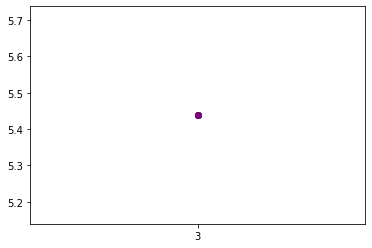

In [42]:
colors = ["red", "blue", "green", "purple"]
def plotter(df, metric):
    print(df)
    for index, row in df.iterrows():
        plt.scatter(row['experiment_id'], row[metric], color=colors[index], label=row['experiment_id'])  

    plt.show()
plotter(get_final_df_results(), "latency_responses")